# Contemporary Study on US Economic Data

Authors:  **Saif Chowdhury** and **Nastaran Oladzadabbasabady**

## Introduction

These days the surge in the United States (US) inflation is one of the hottest topics in the news and almost all of us are experiencing its implications throughout our daily lives.

This project aims to do a brief analysis on the US inflation and the online database, Federal Reserve Economic Data (FRED) is used for this purpose. The type of data available in this website is json. Based on the nature of the economic metric under study, the associated data updates monthly, seasonally, or annually etc. 

The details of connecting to the mentioned database, retrieve the required data, and conduct the analysis are provided in the following sections.

## Sources

The main source of this study is FRED® API, which is a web service that allows developers to write programs and build applications that retrieve economic data from the FRED® and ALFRED® websites hosted by the Economic Research Division of the Federal Reserve Bank of St. Louis. Requests can be customized according to data source, release, category, series, and other preferences.

For documentation regarding Fred API, refer to the following link https://fred.stlouisfed.org/docs/api/fred/#API 

For exploring FRED data, refer to the following link https://fred.stlouisfed.org/

For a more detailed explanation on this study, refer to the following link [YouTube link]

## Connecting to FRED through API

The first step to connect to the FRED® API is to request a private API token. Any individual will be able to generate their private Keys after creating an account in the website.

The Private API keys are then stored in a json file as below to be processed later.

In [16]:
import json
import requests

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [6]:
with open('APIsecret.json', 'r') as f:
    secrets = json.load(f)

api_key = secrets["api_key"]

In the second step, in order to bring achieve code structure and reduce making API calls separately, the class "FredPy" is used. 

Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.

The function below makes the primary call to FRED API and reformats the data to extract the required observation data. If the response is successful, the function extracts the data, otherwise it raises an exception error for bad response from API, which allows for graceful exit of the function. The extracted data are then wrangled using lambda function over assign method to convert columns to datetime and float data types.

In [7]:
class FredPy:

    def __init__(self, token=None):

        self.token = token
        self.url = "https://api.stlouisfed.org/fred/series/observations" + \
                    "?series_id={seriesID}&api_key={key}&file_type=json" + \
                    "&observation_start={start}&observation_end={end}&units={units}"

    def set_token(self, token):
        self.token = token

    def get_series(self, seriesID, start, end, units):

        # The URL string with the values inserted into it
        url_formatted = self.url.format(
            seriesID=seriesID, start=start, end=end, units=units, key=self.token
        )

        response = requests.get(url_formatted)

        if(self.token):
            if(response.status_code == 200):
                data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                        .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                        .assign(value = lambda cols: cols['value'].astype(float))\
                        .rename(columns = {'value': seriesID})

                return data

            else:
                raise Exception("Bad response from API, status code = {}".format(response.status_code))
        else:
            raise Exception("You did not specify an API key.")

In [8]:
fredpy = FredPy()

fredpy.set_token(api_key)


cpiLessFoodEnergy = fredpy.get_series(
    seriesID="CORESTICKM159SFRBATL", 
    start = '1970-01-01',
    end = '2022-03-01', 
    units = 'lin'
)

cpicore = fredpy.get_series(
    seriesID="MEDCPIM158SFRBCLE", 
    start = '1983-01-01',
    end = '2022-03-01', 
    units = 'lin'
)

ppifreghttruck = fredpy.get_series(
    seriesID="PCU484121484121", 
    start = '2000-01-01',
    end = '2022-03-01', 
    units = 'lin'
)

## Extracting and Analyzing Data of Interest

In the sections below, suitable data to study reasons behind inflation as well as its implications are extracted and analyzed.

### CPI (excluding Food and Energy)

The Sticky Price Consumer Price Index (CPI) is calculated from a subset of goods and services included in the CPI that change price relatively infrequently. 

Because these goods and services change price relatively infrequently, they are thought to incorporate expectations about future inflation to a greater degree than prices that change on a more frequent basis. One possible explanation for sticky prices could be the costs firms incur when changing price.

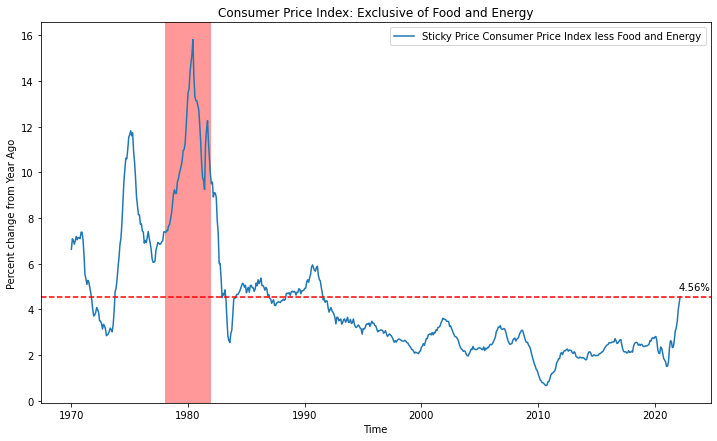

In [9]:
plt.figure(figsize = (12, 7))

plt.plot(cpiLessFoodEnergy['date'], cpiLessFoodEnergy['CORESTICKM159SFRBATL'], label='Sticky Price Consumer Price Index less Food and Energy')


plt.axhline(y = 4.551815, color = 'r', linestyle = '--')
plt.title("Consumer Price Index: Exclusive of Food and Energy")
plt.axvspan(dt.date(1978,1,3), dt.date(1982,1,3), color='r', alpha=0.4, lw=0)
plt.text(dt.date(2022,1,3), 4.851815,'4.56%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.legend()
plt.show()

From the above plot, it can be seen that the inflation rate (as of Febraury 2022) of 4.56 %, is the highest over more than 35 years. Only the high inflationary period of the early 80s beats the current trend, which is mainly due to excessive goverment speeding that cumulated in a spiraling inflation. However, this does not give a full picture as the changes in Food and Energy prices are not included.

The next analysis explores how Consumer Price Index has changed over the years with respect to a broader index (more components like Food and Energy) and try to understand the significance of the current scenario of high inflation.

### Core CPI (Median Consumer Price Index)

CPI (excluding energy and food) does not present the complete picture of economical inflation. So let's explore to see the changes in the Core CPI.

Median Consumer Price Index (CPI) is a measure of core inflation calculated the Federal Reserve Bank of Cleveland and the Ohio State University. Median CPI was created as a different way to get a 'Core CPI' measure, or a better measure of underlying inflation trends. To calculate the Median CPI, the Cleveland Fed analyzes the median price change of the goods and services published by the BLS. 

The median price change is the price change that’s right in the middle of the long list of all of the price changes. This series excludes 49.5% of the CPI components with the highest and lowest one-month price changes from each tail of the price-change distribution resulting in a Median CPI Inflation Estimate.

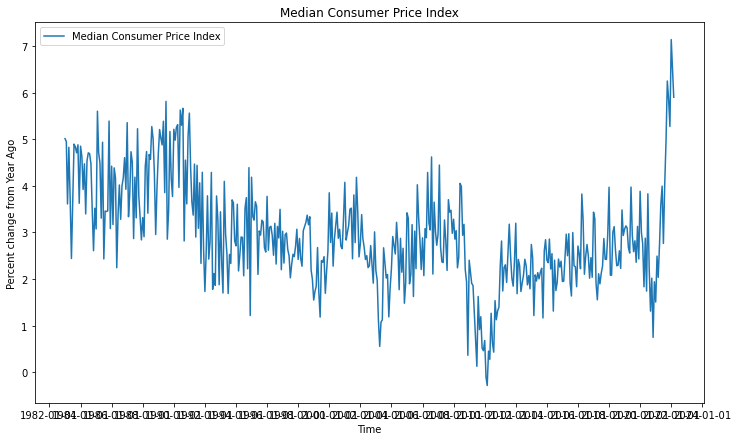

In [10]:
plt.figure(figsize = (12, 7))

plt.plot(cpicore['date'], cpicore['MEDCPIM158SFRBCLE'],
         label='Median Consumer Price Index')
# plt.axhline(y = 4.551815, color = 'r', linestyle = '--')
plt.title("Median Consumer Price Index")

# plt.axvspan(dt.date(1978,1,3), dt.date(1982,1,3), color='r', alpha=0.4, lw=0)
# plt.text(dt.date(2022,1,3), 4.851815,'4.56%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator(base=2))
plt.legend()
plt.show()

It can be seen that a widely fluctuating CPI with large jump at the end with a rate of 6.15 as of February 2022, which is higher than previous CPI index that was seen.

### Moving Average Analysis

A moving analysis of the Median Consumer Price Index should give us a much clearer picture of the changes. Here, we are considering a moving average of 6 months.

          date  MEDCPIM158SFRBCLE
466 2021-11-01           5.855760
467 2021-12-01           5.275819
468 2022-01-01           7.141525
469 2022-02-01           6.506399
470 2022-03-01           5.902594


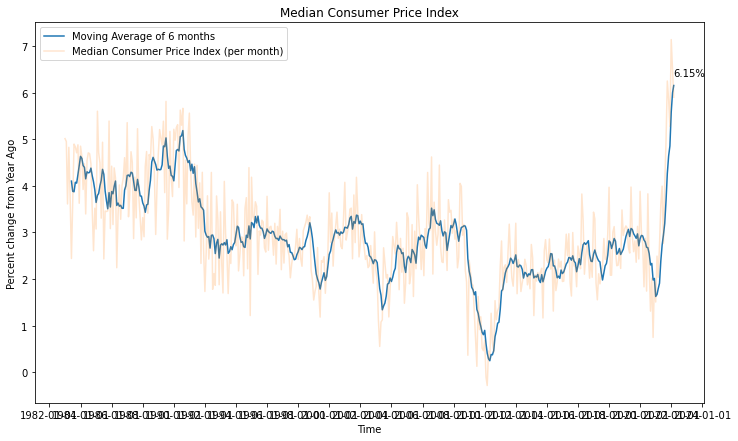

In [11]:
print(cpicore.tail())

cpicore['Y_Predict'] = cpicore.iloc[:,1].rolling(window=6).mean()

plt.figure(figsize = (12, 7))

plt.plot(cpicore['date'], cpicore['Y_Predict'], label='Moving Average of 6 months')
plt.plot(cpicore['date'], cpicore['MEDCPIM158SFRBCLE'], label='Median Consumer Price Index (per month)', alpha=0.2)


plt.title("Median Consumer Price Index")
plt.text(dt.date(2022,3,1), 6.355622,'6.15%')
plt.ylabel('Percent change from Year Ago')
plt.xlabel('Time')
plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator(base=2))
plt.legend()
plt.show()

### Producer Price Index by Industry: General Freight Trucking, Long-Distance Truckload

The Producer Price Index (PPI) program measures the average change over time in the selling prices received by domestic producers for their output. The prices included in the PPI are from the first commercial transaction for many products and some services.

It is usually believed that CPI indicator lags behind PPI. The comparison is made by indexing the 2003 values as 100. 

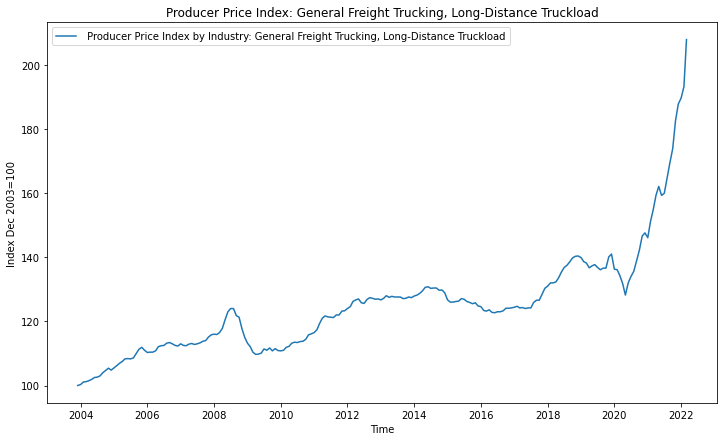

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(ppifreghttruck['date'], ppifreghttruck['PCU484121484121'], label=' Producer Price Index by Industry: General Freight Trucking, Long-Distance Truckload')

plt.title("Producer Price Index: General Freight Trucking, Long-Distance Truckload")
plt.ylabel('Index Dec 2003=100')
plt.xlabel('Time')
plt.legend()
plt.show()

It can be seen that the PPI Index has more than doubled over the last 20 years, with a hugh surge at the end. This, coupled with the fact that CPI lags PPI, shows that the current trend of high inflationary period is likely to continue for some time.

### Two Common Effects of Inflation

Gross Domestic Product (GDP) and Unemployement Rate are two crucial economic metrics affected by inflation. GDP is the monetary value of all finished goods and services made within a country during a specific period, while Unemployment Rate measures the share of workers in the labor force who do not currently have a job but are actively looking for work.

Before studying how inflation affects the mentioned metrics, let's depict the annual percent of change in GDP and Unemploymnet over the past 20 years (form 2000 to 2020).

In [13]:
# Load CPI data (levels)
cpi_data = fredpy.get_series(
    seriesID = 'FPCPITOTLZGUSA', 
    start = '1990-01-01',
    end = '2021-12-01', 
    units = 'lin'
)

# Add column "year" to df
cpi_data.rename(columns = {"FPCPITOTLZGUSA": "CPI"}, inplace = True)
cpi_data['year'] = pd.to_datetime(cpi_data['date']).dt.year

# Load GDP data (levels)
gdp_data = fredpy.get_series(
    seriesID = 'GDP', 
    start = '1990-01-01',
    end = '2020-12-01', 
    units = 'lin'
)

# Add column "year" to df 
gdp_data['year'] = pd.to_datetime(gdp_data['date']).dt.year
gdp_data_annual = gdp_data.groupby(['year']).mean()

# Load GDP data (% change from year ago)
gdp_data_pc = fredpy.get_series(
    seriesID='GDP', 
    start = '1990-01-01',
    end = '2020-12-01', 
    units = 'pc1'
)

gdp_data_pc['year'] = pd.to_datetime(gdp_data_pc['date']).dt.year
gdp_data_annual_pc = gdp_data_pc.groupby(['year']).mean()

# Load unemployment data (levels)
unemployment_data = fredpy.get_series(
    seriesID='UNRATE', 
    start = '1990-01-01',
    end = '2020-12-01', 
    units = 'lin'
)

# Add column "year" to df
unemployment_data['year'] = pd.to_datetime(unemployment_data['date']).dt.year
unemployment_data_annual = unemployment_data.groupby(['year']).mean()

# Load unemployment data (% change from year ago)
unemployment_data_pc = fredpy.get_series(
    seriesID='UNRATE', 
    start = '1990-01-01',
    end = '2020-12-01', 
    units = 'pc1'
)

unemployment_data_pc['year'] = pd.to_datetime(unemployment_data_pc['date']).dt.year
unemployment_data_annual_pc = unemployment_data_pc.groupby(['year']).mean()

Based on the following bar charts, both GDP and Unemployment experienced a sudden change of trend in the year 2020, which makes a lot of sense as Covid 19 pandemic started in the very same year.

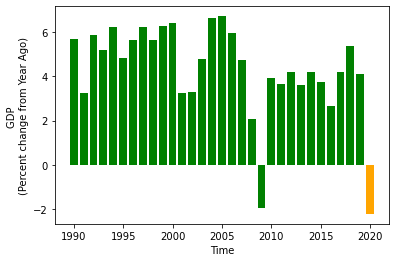

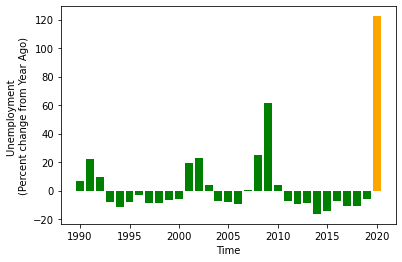

In [14]:
colors = ["green" for i in list(unemployment_data_annual_pc.index)]
colors[-1] = "orange"

plt.bar(list(gdp_data_annual_pc.index), gdp_data_annual_pc['GDP'], color = colors)
plt.xlabel("Time")
plt.ylabel("GDP \n(Percent change from Year Ago)")
plt.show()

plt.bar(list(unemployment_data_annual_pc.index), unemployment_data_annual_pc['UNRATE'], color = colors)
plt.xlabel("Time")
plt.ylabel("Unemployment \n(Percent change from Year Ago)")
plt.show()

Now let's study the correlation between inflation vs. GDP and Unemployemet, using CPI as the inflation measure. For this purpose, "polyfit" function provided by the "matplotlib" library is applied.

Both of the plots below, demonstrate a negative correlation, meaning the higher the inflation is, the lower GDP and Unemployment Rate is expected. It can also be seen that there exists a stronger correlation between CPI and GDP compared to that of Unemployment.

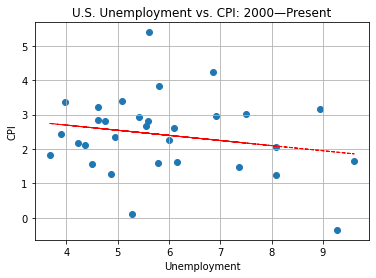

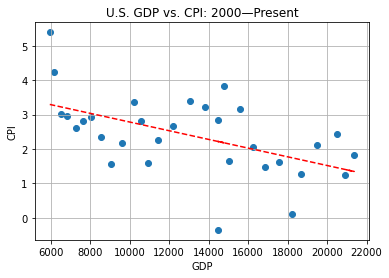

In [17]:
x_1 = unemployment_data_annual['UNRATE']
y = cpi_data['CPI']

a_1, b_1 = np.polyfit(x_1, y, 1)

plt.scatter(x_1, y)
plt.plot(x_1, a_1*x_1+b_1, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Unemployment")
plt.ylabel("CPI")
plt.title("U.S. Unemployment vs. CPI: 2000—Present")
plt.grid()
plt.show()

x_2 = gdp_data_annual['GDP']
y = cpi_data['CPI']

a_2, b_2 = np.polyfit(x_2, y, 1)

plt.scatter(x_2, y)
plt.plot(x_2, a_2*x_2+b_2, color='red', linestyle='dashed', linewidth=1.5)
plt.xlabel("GDP")
plt.ylabel("CPI")
plt.title("U.S. GDP vs. CPI: 2000—Present")
plt.grid()
plt.show()

### Inflation Prediction

At the end, Linear Regression is applied to predict CPI for the next four years. 

The "sklearn" library has a "LinearRegression" tool, which fits a regression line to the available data. The resulting line can then be applied to predict future values of the dependent variable (CPI in our study).

The Mean Absolute Error of the applied Linear Regression suggests that although the prediction is not terribly perfect, it can provide relatively good estimates for a short period of time ahead. 

In [18]:
y = np.array(cpi_data['CPI'])
y = y.reshape(y.shape[0], 1)

x = np.array(cpi_data['year'])
x = x.reshape(x.shape[0], 1)

model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
print('Mean Absolute Error of the Linear Regression: ', mean_absolute_error(y, y_pred))

x_new = np.array([[2021],[2022],[2023], [2024]])
y_new = model.predict(x_new)
y_new = y_new.reshape(y_new.shape[0],)

year_list = ['2021', '2022', '2023', '2024']
CPI_pred = pd.DataFrame({'Year': year_list,'Predicted CPI': y_new})

print('\n')
print('The predicted values for CPI are as follows:')
CPI_pred

Mean Absolute Error of the Linear Regression:  0.7142623161596219


The predicted values for CPI are as follows:


,Year,Predicted CPI
0,2021,1.261860
1,2022,1.190164
2,2023,1.118469
3,2024,1.046773


## Suggestions

There definitely exits a long list of approaches that can improve the prediction conducted above such as, using Non-Linear Regression or more advanced Machine Learning tools, which is out of the scope of this assignment. Applying such algorithms instead of Linear Regression and comparing their performances can be an interesting topic for further studies.